## Importing libraries

In [1]:
import csv
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()
from datetime import datetime, timedelta

We will explore the behavior of users from county_5. The cohort is defined as the date of the user's first return to read something on our blog. As time passes, we track whether the user makes a purchase each day or not.

## We need two tables: 1. the 'returning_readers' and 2. the 'purchases'.

In [56]:
returning_readers = pd.read_csv('returning_readers.csv', delimiter = ';', names=['my_date', 'event_type', 'country', 'user_id', 'continent'])

In [57]:
purchases = pd.read_csv('purchases.csv', delimiter = ';', names=['my_date', 'event_type', 'user_id', 'paid'])

In [58]:
# form my_date columns to yyyy-mm-dd

In [59]:

returning_readers['my_date'] = pd.to_datetime(returning_readers['my_date'])
purchases['my_date'] = pd.to_datetime(purchases['my_date'])


returning_readers['my_date'] = returning_readers['my_date'].dt.strftime('%Y-%m-%d')
purchases['my_date'] = purchases['my_date'].dt.strftime('%Y-%m-%d')

In [60]:
returning_readers.head()

,my_date,event_type,country,user_id,continent
0,2018-01-01,read,country_5,2458151287,North America
1,2018-01-01,read,country_4,2458151279,Asia
2,2018-01-01,read,country_4,2458151525,Africa
3,2018-01-01,read,country_5,2458151287,Asia
4,2018-01-01,read,country_5,2458151315,South America


In [61]:
purchases.tail()

,my_date,event_type,user_id,paid
8402,2018-03-30,buy,2458330984,80
8403,2018-03-30,buy,2458180092,8
8404,2018-03-30,buy,2458331539,80
8405,2018-03-30,buy,2458339835,80
8406,2018-03-30,buy,2458264806,8


In [78]:
# create a cohort dictionary

start_date = datetime(2018, 1, 1)  
end_date = datetime(2018, 3, 25)  

dates_dict = {}

current_date = start_date
while current_date <= end_date:
    dates_dict[current_date.strftime('%Y-%m-%d')] = []  
    current_date += timedelta(days=1)  

In [63]:
# keeping the firt appearing user_ids
cohort_returning_readers = returning_readers.drop_duplicates(subset='user_id', keep='first')


In [64]:
# we only keep the rows with country_5
cohort_returning_readers_c5 = cohort_returning_readers[cohort_returning_readers['country'].isin(['country_5'])]

In [65]:
cohort_returning_readers_c5

,my_date,event_type,country,user_id,continent
0,2018-01-01,read,country_5,2458151287,North America
4,2018-01-01,read,country_5,2458151315,South America
5,2018-01-01,read,country_5,2458151302,South America
10,2018-01-01,read,country_5,2458151585,North America
14,2018-01-01,read,country_5,2458151685,Asia
...,...,...,...,...,...
371826,2018-03-31,read,country_5,2458360940,North America
371828,2018-03-31,read,country_5,2458361188,Asia
371832,2018-03-31,read,country_5,2458361105,Asia
371842,2018-03-31,read,country_5,2458361240,North America


In [66]:
cohort_returning_readers_c5.shape

(19477, 5)

In [67]:
# we need to merge the two tables in order to have a complete overview of the data
data_final = pd.merge(cohort_returning_readers_c5, purchases, how = 'outer',  on = 'user_id')

In [68]:
data_final.value_counts()

my_date_x   event_type_x  country    user_id     continent      my_date_y   event_type_y  paid
2018-03-26  read          country_5  2458346214  Europe         2018-03-28  buy           8.0     1
2018-02-12  read          country_5  2458238924  North America  2018-02-20  buy           80.0    1
2018-02-13  read          country_5  2458239191  North America  2018-02-15  buy           8.0     1
                                     2458239173  Asia           2018-02-15  buy           8.0     1
                                     2458238989  Asia           2018-02-21  buy           80.0    1
                                                                                                 ..
2018-03-06  read          country_5  2458291533  Asia           2018-03-09  buy           8.0     1
                                     2458291190  Asia           2018-03-18  buy           80.0    1
                                                                2018-03-13  buy           8.0     1
     

In [69]:
data_final.paid.sum()

194480.0

In [70]:
data_final[data_final['paid'].isin(['8'])]

,my_date_x,event_type_x,country,user_id,continent,my_date_y,event_type_y,paid
5,2018-01-01,read,country_5,2458151500,Australia,2018-01-04,buy,8.0
6,2018-01-01,read,country_5,2458151481,North America,2018-01-02,buy,8.0
10,2018-01-01,read,country_5,2458151919,South America,2018-01-02,buy,8.0
11,2018-01-01,read,country_5,2458152315,Asia,2018-01-01,buy,8.0
14,2018-01-01,read,country_5,2458152536,Africa,2018-01-05,buy,8.0
...,...,...,...,...,...,...,...,...
25908,NaN,NaN,NaN,2458341594,NaN,2018-03-30,buy,8.0
25909,NaN,NaN,NaN,2458306701,NaN,2018-03-30,buy,8.0
25910,NaN,NaN,NaN,2458263176,NaN,2018-03-30,buy,8.0
25911,NaN,NaN,NaN,2458181019,NaN,2018-03-30,buy,8.0


In [71]:
# create an important column
cohort_sum_first_time_returned = data_final.groupby('my_date_x').count()[['user_id']].rename(columns={'user_id': 'num_of_returned_readers'})
cohort_sum_first_time_returned

,num_of_returned_readers
my_date_x,
2018-01-01,19
2018-01-02,14
2018-01-03,12
2018-01-04,37
2018-01-05,31
...,...
2018-03-27,448
2018-03-28,312
2018-03-29,536


<AxesSubplot:xlabel='my_date_x'>

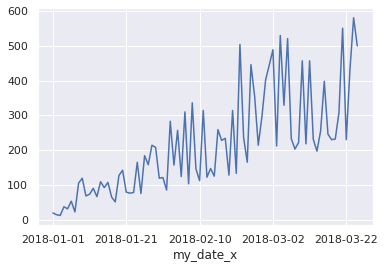

In [113]:
cohort_sum_first_time_returned['num_of_returned_readers'].plot()

## drop 'NaN' rows

In [72]:
data_final2 = data_final.loc[data_final['my_date_y'].notnull()]
data_final2 = data_final2.loc[data_final2['my_date_x'].notnull()]

In [73]:
# income_from country_5
data_final2.paid.sum()

57920.0

In [74]:
# testig the elapsed days part
date_of_read = datetime.strptime('2018-01-01', '%Y-%m-%d')
date_of_purchase = datetime.strptime('2018-01-03', '%Y-%m-%d')
delta = date_of_purchase - date_of_read
elapsed_days = delta.days
print(elapsed_days) 

2


In [75]:
# cohort max 2018-03-25
data_final3 = data_final2.loc[data_final2['my_date_x'] <= '2018-03-25']

In [80]:
# Filling the "dates" dictionary with purchase data, the number of days from the first return to read an article, and whether a product was purchased.
for _, row in data_final3.iterrows():
    date_of_read = datetime.strptime (row['my_date_x'], '%Y-%m-%d')
    date_of_purchase = datetime.strptime(row['my_date_y'], '%Y-%m-%d')
    delta = date_of_purchase - date_of_read  # a két dátum közötti időszak
    elapsed_days = delta.days      # az eltelt napok száma
    dates_dict[row['my_date_x']].append(elapsed_days)

In [84]:
# test dates dict
dates_dict['2018-02-01']

[5, 5, 4, 3, 4, 5, 7, 4, 6, 5, 5, 5, 5, 8, 3, 3, 3, 7, 3, 3]

In [87]:
data_final3[data_final3['my_date_x'] == '2018-02-01']


,my_date_x,event_type_x,country,user_id,continent,my_date_y,event_type_y,paid
2879,2018-02-01,read,country_5,2458212775,Asia,2018-02-06,buy,8.0
2880,2018-02-01,read,country_5,2458212775,Asia,2018-02-06,buy,80.0
2884,2018-02-01,read,country_5,2458212918,Europe,2018-02-05,buy,8.0
2885,2018-02-01,read,country_5,2458212808,Africa,2018-02-04,buy,8.0
2886,2018-02-01,read,country_5,2458212765,Europe,2018-02-05,buy,8.0
2889,2018-02-01,read,country_5,2458213217,Asia,2018-02-06,buy,8.0
2890,2018-02-01,read,country_5,2458213217,Asia,2018-02-08,buy,80.0
2893,2018-02-01,read,country_5,2458212928,Europe,2018-02-05,buy,8.0
2894,2018-02-01,read,country_5,2458212928,Europe,2018-02-07,buy,80.0
2900,2018-02-01,read,country_5,2458212995,North America,2018-02-06,buy,8.0


In [88]:
# the slowest customer
max(max(dates_dict.values()))

18

In [91]:
# creating our new data table
# First, we create an empty numpy array with the number of rows equal to the number of rows in the original dataframe
num_rows = cohort_sum_first_time_returned.shape[0]
new_cols = 19  # the number of columns ranges from 0 to 18
new_data = np.zeros((num_rows, new_cols))

# Create the new dataframe from the numpy array, where the row and column names are simple integers
new_df = pd.DataFrame(new_data, columns=[i for i in range(new_cols)], index=cohort_sum_first_time_returned.index)

# Concatenate the two dataframes along the columns
cohort_sum_first_time_returned = pd.concat([cohort_sum_first_time_returned, new_df], axis=1)

# Set the values under the new columns to 0
cohort_sum_first_time_returned.loc[:, range(new_cols)] = 0

In [92]:
cohort_sum_first_time_returned

,num_of_returned_readers,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
my_date_x,,,,,,,,,,,,,,,,,,,,
2018-01-01,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-02,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-03,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-04,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-05,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-27,448,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-28,312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-29,536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
cohort_sum_first_time_returned = cohort_sum_first_time_returned.loc[:'2018-03-25']

In [96]:
final_data = cohort_sum_first_time_returned

In [98]:
final_data = final_data.drop('num_of_returned_readers', axis=1)

In [100]:
# fill the df
# for date, row in results_cohort.iterrows():
for dates in dates_dict.keys():
    for value in dates_dict[dates]:
        final_data.loc[dates, value] = final_data.loc[dates, value] +1

In [103]:
final_data.head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
my_date_x,,,,,,,,,,,,,,,,,,,
2018-01-01,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-02,0,1,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-03,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-04,0,0,5,1,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2018-01-05,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-06,0,0,2,1,3,4,2,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-07,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-08,0,0,2,9,2,5,3,1,0,0,0,0,0,0,0,0,0,0,0
2018-01-09,0,0,3,5,3,4,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Creating a heat map 1.0... but not the best for the eyes...

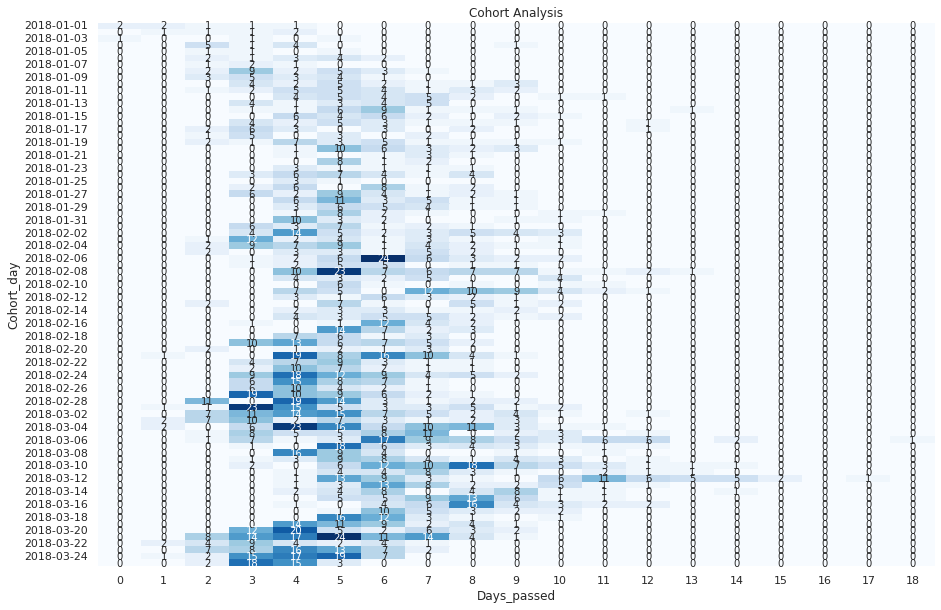

In [106]:
# import seaborn as sns
# import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(final_data, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 10}, cbar=False)
plt.title('Cohort Analysis')
plt.xlabel('Days_passed')
plt.ylabel('Cohort_day')
plt.show()


In [ ]:
# Creating a heat map.2.0

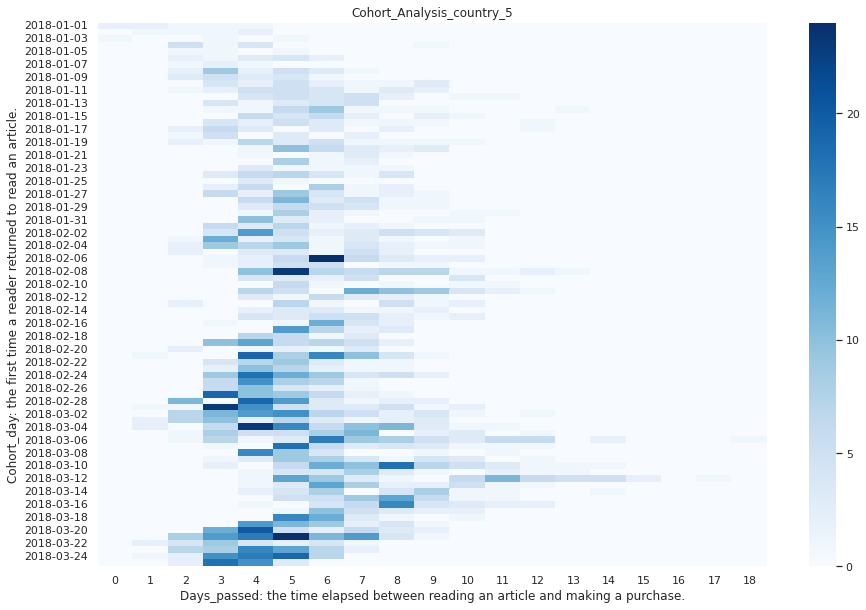

In [108]:
# import seaborn as sns
# import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(final_data, annot=False, cmap='Blues')
plt.title('Cohort_Analysis_country_5')
plt.xlabel('Days_passed: the time elapsed between reading an article and making a purchase.')
plt.ylabel('Cohort_day: the first time a reader returned to read an article.')
plt.show()
